# Embedding a Feedforward Cascade in a Recurrent Network

[**Alex Williams**](http://alexhwilliams.info) 10/24/2015

If you are viewing a static version of this notebook (e.g. on nbviewer), you can launch an interactive session by clicking below:

[![Binder](http://mybinder.org/badge.svg)](http://mybinder.org/repo/ahwillia/RecNetLearn/tutorials/FORCE_Learning_recurrent_feedforward.ipynb)

There has been renewed interest in feedforward networks in both theoretical ([Ganguli et al., 2008](http://dx.doi.org/10.1073/pnas.0804451105); [Goldman, 2009](http://dx.doi.org/10.1016/j.neuron.2008.12.012); [Murphy & Miller, 2009](http://dx.doi.org/10.1016/j.neuron.2009.02.005)) and experimental ([Long et al. 2010](http://dx.doi.org/10.1038/nature09514); [Harvey et al. 2012](http://dx.doi.org/10.1038/nature10918)) neuroscience lately. On a structural level, most neural circuits under study are highly recurrent. However, recurrent networks can still encode simple feedforward dynamics as we'll show in this notebook (also see [Ganguli & Latham, 2009](http://ganguli-gang.stanford.edu/pdf/Preview.Neuron.09.pdf), for an intuitive overview).

<img src="./feedforward.png" width=450>

In [1]:
from __future__ import division
from scipy.integrate import odeint,ode
from numpy import zeros,ones,eye,tanh,dot,outer,sqrt,linspace,pi,exp,tile,arange,reshape
from numpy.random import uniform,normal,choice
import pylab as plt
import numpy as np
%matplotlib inline

### Methods

Consider a recurrent network initialized with random connectivity. We split the network into two groups &mdash; neurons in the first group participate in the feedforward cascade, and neurons in the second group do not. We use recursive least-squares to train the presynaptic weights for each of the neurons in the cascade. The presynaptic weights for the second group of neurons are left untrained.

The second group of neurons provides chaotic behavior that helps stabilize and time the feedforward cascade. *This is necessary for the target feedforward cascade used in this example*. The intrinsic dynamics of the system are too fast to match the slow timescale of the target pattern we use.

<img src="./rec-ff-net.png" width=600>

We previously applied FORCE learning to the output/readout weights of a recurrent network ([see notebook here](./FORCE_Learning.ipynb)). In this case we will train a subset of the recurrent connections in the network (blue lines in the schematic above). This is described in the supplemental materials of [Susillo & Abbott (2009)](http://dx.doi.org/10.1016/j.neuron.2009.07.018). We start with random initial synaptic weights for all recurrent connections and random weights for the input stimulus to the network.<sup><a href="#f1b" id="f1t">**[1]**</a></sup> The dynamics are given by:

$$\mathbf{\dot{x}} = -\mathbf{x} + J \tanh(\mathbf{x}) + \mathbf{u}(t)$$

where $\mathbf{x}$ is a vector holding the activation of all neurons, the firing rates are $\tanh(\mathbf{x})$, the matrix $J$ holds the synaptic weights of the recurrent connections, and $\mathbf{u}(t)$ is the input/stimulus, which is applied in periodic step pulses.

Each neuron participating in the feedforward cascade/sequence has a target function for its firing rate. We use a Gaussian for this example:

$$f_i(t) = 2 \exp \left [ \frac{-(t-\mu_i)^2}{18} \right ] - 1$$

where $\mu_i$ is the time of peak firing for neuron $i$. Here, $t$ is the time since the last stimulus pulse was delivered &mdash; to reiterate, we repeatedly apply the stimulus as a step pulse during training.

We apply recursive least-squares to train the pre-synaptic weights for each neuron participating in the cascade. Denote the $i$<sup>th</sup> row of $J$ as $\mathbf{j}_i$ (these are the presynaptic inputs to neuron $i$). For each neuron, we store a running estimate of the inverse correlation matrix, $P_i$, and use this to tune our update of the presynaptic weights:

$$\mathbf{q} = P_i \tanh [\mathbf{x}]$$

$$c = \frac{1}{1+ \mathbf{q}^T \tanh(\mathbf{x})}$$

$$\mathbf{j}_i \rightarrow \mathbf{j}_i + c(f_i(t)- \tanh (x_i) ) \mathbf{q}$$

$$P_{i} \rightarrow P_{i} - c \mathbf{q} \mathbf{q}^T$$

We initialize each $P_i$ to the identity matrix at the beginning of training.

### Training the Network

In [2]:
## Network parameters and initial conditions
N1 = 20 # neurons in chain
N2 = 20 # neurons not in chain
N = N1+N2
tI = 10
J = normal(0,sqrt(1/N),(N,N))
x0 = uniform(-1,1,N)
tmax = 2*N1+2*tI
dt = 0.5
u = uniform(-1,1,N)
g = 1.5

## Target firing rate for neuron i and time t0
target = lambda t0,i: 2.0*exp(-(((t0%tmax)-(2*i+tI+3))**2)/(2.0*9)) - 1.0

def f1(t0,x):
    ## input to network at beginning of trial
    if (t0%tmax) < tI: return -x + g*dot(J,tanh_x) + u
    ## no input after tI units of time
    else: return -x + g*dot(J,tanh_x)

P = []
for i in range(N1):
    # Running estimate of the inverse correlation matrix
    P.append(eye(N))

lr = 1.0 # learning rate

# simulation data: state, output, time, weight updates
x,z,t,wu = [x0],[],[0],[zeros(N1).tolist()]

# Set up ode solver
solver = ode(f1)
solver.set_initial_value(x0)

# Integrate ode, update weights, repeat
while t[-1] < 25*tmax:
    tanh_x = tanh(x[-1]) # cache firing rates
    wu.append([])
    
    # train rates at the beginning of the simulation
    if t[-1]<22*tmax:
        for i in range(N1):
            error = target(t[-1],i) - tanh_x[i]
            q = dot(P[i],tanh_x)
            c = lr / (1 + dot(q,tanh_x))
            P[i] = P[i] - c*outer(q,q)
            J[i,:] += c*error*q
            wu[-1].append(np.sum(np.abs(c*error*q)))
    else:
        # Store zero for the weight update
        for i in range(N1): wu[-1].append(0)
        
    solver.integrate(solver.t+dt)
    x.append(solver.y)
    t.append(solver.t)

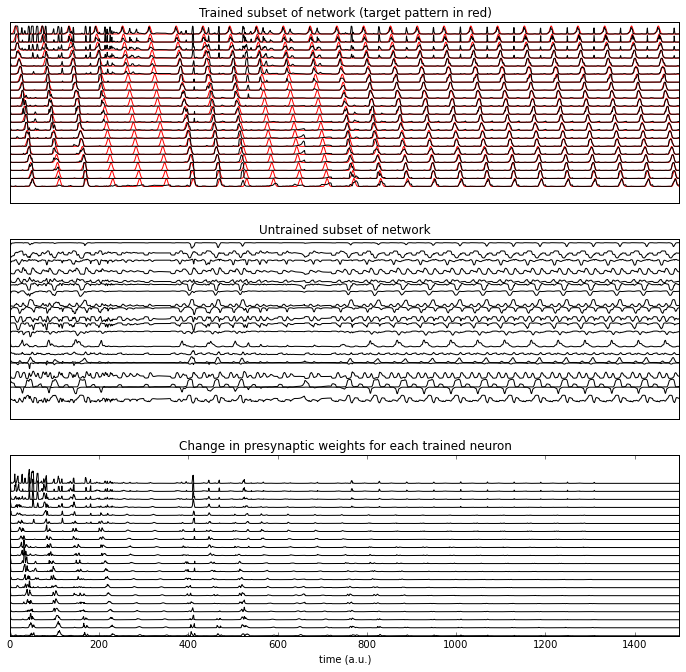

In [3]:
x = np.array(x)
r = tanh(x) # firing rates
t = np.array(t)
wu = np.array(wu)
wu = reshape(wu,(len(t),N1))

pos = 2*arange(N)
offset = tile(pos[::-1],(len(t),1))
targ = np.array([target(t,i) for i in range(N1)]).T

plt.figure(figsize=(12,11))
plt.subplot(3,1,1)
plt.plot(t,targ + offset[:,:N1],'-r')
plt.plot(t,r[:,:N1] + offset[:,:N1],'-k')
plt.yticks([]),plt.xticks([]),plt.xlim([t[0],t[-1]])
plt.title('Trained subset of network (target pattern in red)')
plt.subplot(3,1,2)
plt.plot(t,r[:,N1:] + offset[:,N1:],'-k')
plt.yticks([]),plt.xticks([]),plt.xlim([t[0],t[-1]])
plt.title('Untrained subset of network')
plt.subplot(3,1,3)
plt.plot(t,wu + offset[:,:N1],'-k')
plt.yticks([]),plt.xlim([t[0],t[-1]]),plt.xlabel('time (a.u.)')
plt.title('Change in presynaptic weights for each trained neuron')
plt.show()

### Test the behavior

We want the network to only produce a feedforward cascade only in response to a stimulus input. Note that this doesn't *always* work &mdash; it is difficult for the network to perform this task. Nonetheless, the training works pretty well most of the time.<sup><a href="#f2b" id="f2t">**[2]**</a></sup>

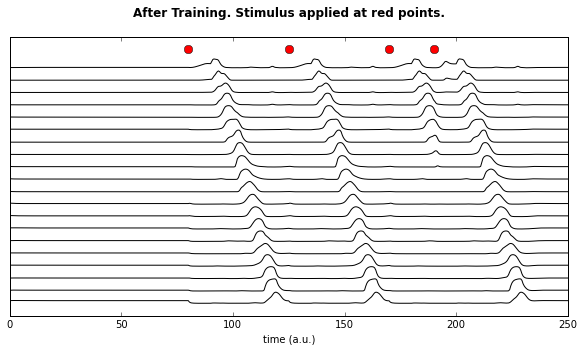

In [4]:
tstim = [80,125,170,190]

def f2(t0,x):
    ## input to network at beginning of trial
    for ts in tstim:
        if t0 > ts and t0 < ts+tI: return -x + g*dot(J,tanh(x)) + u
    ## no input after tI units of time
    return -x + g*dot(J,tanh(x))

# Set up ode solver
solver = ode(f2)
solver.set_initial_value(x[-1,:])

x_test,t_test = [x[-1,:]],[0]
while t_test[-1] < 250:
    solver.integrate(solver.t + dt)
    x_test.append(solver.y)
    t_test.append(solver.t)

x_test = np.array(x_test)
r_test = tanh(x_test) # firing rates
t_test = np.array(t_test)

pos = 2*arange(N)
offset = tile(pos[::-1],(len(t_test),1))

plt.figure(figsize=(10,5))
plt.plot(t_test,r_test[:,:N1] + offset[:,:N1],'-k')
plt.plot(tstim,ones(len(tstim))*80,'or',ms=8)
plt.ylim([37,82]), plt.yticks([]), plt.xlabel('time (a.u.)')
plt.title('After Training. Stimulus applied at red points.\n',fontweight='bold')
plt.show()

Note that when we apply two inputs in quick succession (the last two inputs) the feedforward cascade restarts.

### Connectivity matrix

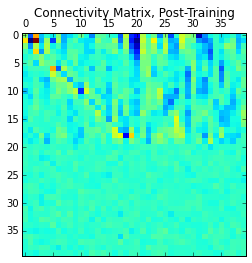

In [5]:
plt.matshow(J)
plt.title("Connectivity Matrix, Post-Training")

**Notes:**

<a href="#f1t" id="f1b">**[1]**</a> Note that the schematic network only shows a subset of the connections between neurons &mdash; showing all connections does not make for a nice illustration. In reality, the neurons are all-to-all connected and the stimulus projects with different weights to all neurons. All connections can be either inhibitory or excitatory and can flip sign during training.

<a href="#f2t" id="f2b">**[2]**</a> As always, [email me](http://alexhwilliams.info) if you have tricks, corrections, or other improvements to add to the code.

**License:**

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br>This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.